# Parte 2

## Árboles de Decisión

### Exploración, Preprocesamiento y Transformación de Datos

#### Imports

In [1]:
import numpy as np 
import pandas as pd
import re 

import matplotlib.pyplot as plt
import seaborn as sns

import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem import SnowballStemmer

import eli5

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from string import punctuation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib

#### Importación del Dataframe

In [2]:
df = pd.read_csv('../csv/hotel_bookings.csv', encoding='latin-1')
bookings = df.copy()
bookings.T

,0,1,2,3,4,5,6,7,8,9,...,119380,119381,119382,119383,119384,119385,119386,119387,119388,119389
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,...,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel,City Hotel
is_canceled,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
lead_time,342,737,7,13,14,14,0,9,85,75,...,44,188,135,164,21,23,102,34,109,205
arrival_date_year,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
arrival_date_month,July,July,July,July,July,July,July,July,July,July,...,August,August,August,August,August,August,August,August,August,August
arrival_date_week_number,27,27,27,27,27,27,27,27,27,27,...,35,35,35,35,35,35,35,35,35,35
arrival_date_day_of_month,1,1,1,1,1,1,1,1,1,1,...,31,31,30,31,30,30,31,31,31,29
stays_in_weekend_nights,0,0,0,0,0,0,0,0,0,0,...,1,2,2,2,2,2,2,2,2,2
stays_in_week_nights,0,0,1,1,2,2,2,2,3,3,...,3,3,4,4,5,5,5,5,5,7
adults,2,2,1,1,2,2,2,2,2,2,...,2,2,3,2,2,2,3,2,2,2


#### Descripción de los Datos

Prepararemos un dataframe donde cada índice, representa un feature del dataset y el mismo estará asociado a su data type correspondiente.

In [3]:
types = pd.DataFrame(bookings.dtypes).rename(columns = {0: 'Data Type'}, inplace=False)
types

,Data Type
hotel,object
is_canceled,int64
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


Ahora debemos ver que datos de estos son categóricos y marcarlos.

In [50]:
invalid_values = {'', 'nan'}
discrete_features_list = ['is_canceled', 'meal', 'market_segment', 'distribution_channel', 
                          'is_repeated_guest', 'reserved_room_type', 'assigned_room_type',
                          'deposit_type', 'customer_type', 'reservation_status']
discrete_features = dict()

for f in discrete_features_list:
    discrete_features[f] = {i for i in set(bookings[f].unique()) if i not in invalid_values}

discrete_features

{'is_canceled': {0, 1},
 'meal': {'BB', 'FB', 'HB', 'SC', 'Undefined'},
 'market_segment': {'Aviation',
  'Complementary',
  'Corporate',
  'Direct',
  'Groups',
  'Offline TA/TO',
  'Online TA',
  'Undefined'},
 'distribution_channel': {'Corporate', 'Direct', 'GDS', 'TA/TO', 'Undefined'},
 'is_repeated_guest': {0, 1},
 'reserved_room_type': {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L', 'P'},
 'assigned_room_type': {'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'P'},
 'deposit_type': {'No Deposit', 'Non Refund', 'Refundable'},
 'customer_type': {'Contract', 'Group', 'Transient', 'Transient-Party'},
 'reservation_status': {'Canceled', 'Check-Out', 'No-Show'}}

Y los actualizamos en el dataframe de tipos.

Y ahora tenemos una forma más simple de ver que representa cada feature; sabemos que si es categórica (es decir, presenta una cantidad discreta de valores), booleana (representado por un cero o un uno), numérica (enteros o de punto flotante) u ordinales (object types). Aclaramos que los "Undefined" representan casos donde ninguno de los otros valores representa la reserva en cuestión, es decir, sería mejor reemplazarlos por un "None".

In [5]:
for f in discrete_features_list:
    types.at[f, 'Data Type'] = discrete_features[f]

types

,Data Type
hotel,object
is_canceled,"{0, 1}"
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


A continuación indicamos que representa cada columna del dataframe:

- **hotel:** Nombre del hotel.
- **is_cancelled:** Indica si la reserva fue cancelada.
- **lead_time:** Días entre que se hace la reserva y la persona que reservó llega al hotel.
- **arrival_date_year:** Año de llegada.
- **arrival_date_month:** Mes de llegada.
- **arrival_date_week_number:** Nombre de la semana de llegada.
- **arrival_date_day_of_month:** Día del mes de llegada.
- **stays_in_weekend_nights:** Noches de fin de semana reservadas.
- **stays_in_week_nights:** Noches durante la semana reservadas.
- **adults:** Número de adultos.
- **children:** Número de niños.
- **babies:** Número de bebes.
- **meal:** Indica los platos cubiertos por el hotel.
- **country:** Código del país.
- **market_segment:** Forma de reserva.
- **distribution_channel:** Canal de distribución de la reserva.
- **is_repeated_guest:** Indica si la(s) persona(s) repite(n) la reserva.
- **previous_cancellations:** Cantidad de reservas canceladas por el mismo cliente en el pasado.
- **previous_bookings_not_canceled:** Cantidad de reservas no canceladas por el mismo cliente en el pasado.
- **reserved_room_type:** Código del tipo de habitación reservada.
- **assigned_room_type:** Número de habitación reservada.
- **booking_changes:** Número de cambios en la reserva.
- **deposit_type:** Forma en la que el cliente deposita el dinero de la reserva.
- **agent:** Código de la agencia que realizó la reserva.
- **company:** Companía que realizó la reserva.
- **days_in_waiting_list:** Días en la lista de espera.
- **customer_type:** Tipo de consumidor.
- **adr:** Beneficio total dividido entre la cantidad total de habitaciones disponibles.
- **required_car_parking_spaces:** Cantidad de lugares de estacionamiento pedidos por el cliente.
- **total_of_special_requests:** Cantidad de pedidos especiales por el cliente.
- **reservation_status:** Estado de la reserva.
- **reservation_status_date:** Fecha en el que se setteó por última vez el estado de la reserva.



Se pide ver también como aparecen las variables categóricas, por lo que vamos a ver los porcentajes de aparición de cada uno:

In [70]:
for f in discrete_features_list:
    print(f"\n{pd.DataFrame(bookings[f].value_counts(normalize=True))}\n")


   is_canceled
0     0.629584
1     0.370416


               meal
BB         0.773180
HB         0.121141
SC         0.089203
Undefined  0.009791
FB         0.006684


               market_segment
Online TA            0.473046
Offline TA/TO        0.202856
Groups               0.165935
Direct               0.105587
Corporate            0.044350
Complementary        0.006223
Aviation             0.001985
Undefined            0.000017


           distribution_channel
TA/TO                  0.819750
Direct                 0.122665
Corporate              0.055926
GDS                    0.001617
Undefined              0.000042


   is_repeated_guest
0           0.968088
1           0.031912


   reserved_room_type
A            0.720278
D            0.160826
E            0.054737
F            0.024265
G            0.017539
B            0.009364
C            0.007806
H            0.005034
P            0.000101
L            0.000050


   assigned_room_type
A            0.620261
D          

#### Variables Faltantes

Se nos pide ver la cantidad de valores faltantes por cada feature.

In [48]:
nan_features = pd.isnull(bookings).sum()  
nan_features[nan_features > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

#### Correlaciones con la Cancelación

In [81]:
cancelation_corrs = bookings.corr()['is_canceled']
cancelation_corrs = cancelation_corrs[cancelation_corrs < 1].nlargest(4)
top_cancelation_corrs = list(cancelation_corrs.index)
cancelation_corrs

lead_time                 0.293123
previous_cancellations    0.110133
adults                    0.060017
days_in_waiting_list      0.054186
Name: is_canceled, dtype: float64

In [82]:
top_cancelation_corrs

['lead_time', 'previous_cancellations', 'adults', 'days_in_waiting_list']

array([[<AxesSubplot:xlabel='lead_time', ylabel='lead_time'>,
        <AxesSubplot:xlabel='previous_cancellations', ylabel='lead_time'>,
        <AxesSubplot:xlabel='adults', ylabel='lead_time'>,
        <AxesSubplot:xlabel='days_in_waiting_list', ylabel='lead_time'>,
        <AxesSubplot:xlabel='is_canceled', ylabel='lead_time'>],
       [<AxesSubplot:xlabel='lead_time', ylabel='previous_cancellations'>,
        <AxesSubplot:xlabel='previous_cancellations', ylabel='previous_cancellations'>,
        <AxesSubplot:xlabel='adults', ylabel='previous_cancellations'>,
        <AxesSubplot:xlabel='days_in_waiting_list', ylabel='previous_cancellations'>,
        <AxesSubplot:xlabel='is_canceled', ylabel='previous_cancellations'>],
       [<AxesSubplot:xlabel='lead_time', ylabel='adults'>,
        <AxesSubplot:xlabel='previous_cancellations', ylabel='adults'>,
        <AxesSubplot:xlabel='adults', ylabel='adults'>,
        <AxesSubplot:xlabel='days_in_waiting_list', ylabel='adults'>,
        <A

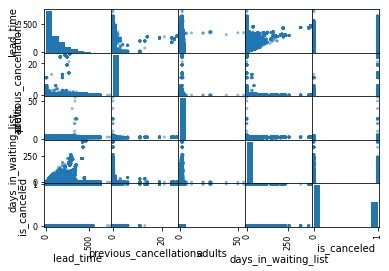

In [91]:
pd.plotting.scatter_matrix(bookings[top_cancelation_corrs + ['is_canceled']])

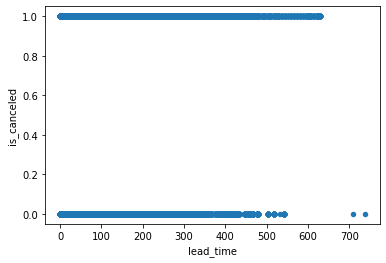

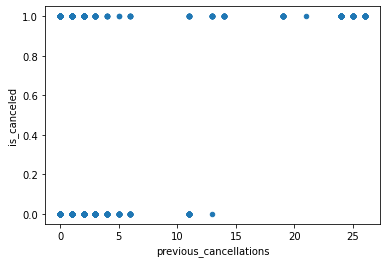

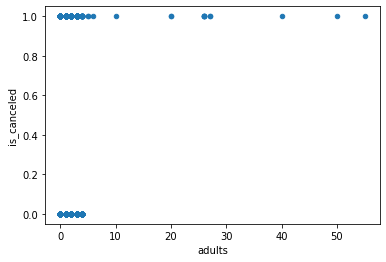

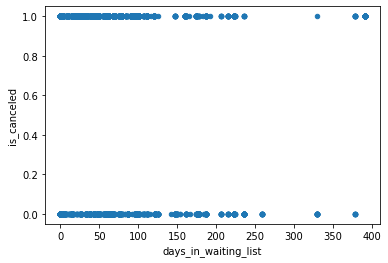

In [87]:
for f in top_cancelation_corrs:
    bookings[[f, 'is_canceled']].plot.scatter(x = f, y = 'is_canceled')

#### Limpieza del Dataset

## Generación y Evaluación de Modelos

### Árbol de Decisión

#### Entrenamiento

#### Gráfico del Modelo

#### Performance Review

### Random Forest

#### Entrenamiento

#### Gráfico del Modelo

#### Performance Review